# Main Notebook for Dutch Dyslexia Programme (DDP)

1. [Load and sort data and metadata](#1)
2. [The DDP Experiment](#2)
3. [Processing](#3)
4. [Analysing event related potentials](#4)

#### Import Packages

In [1]:
import mne
import numpy as np
import pandas as pd
import os
import glob
import ipywidgets
import wave # For analyzing .wav audio files

from functions import data
from functions import processing
from functions import display_helper

from functions.ddp import DDP
ddp = DDP()

import local_paths

<br>
<br>


---
<a id='1'></a>
## 1. Load and sort data and metadata

#### Create labels from raw .cnt files.

+ The label columns are: filename / code / age_group / age_days
+ The 'create_labels_raw' function takes as inut the dataset location, and the directory where the age metadata is stored

In [2]:
directory_age_metadata = os.path.join(local_paths.DDP_metadata, "ages")
df_raw = ddp.create_labels_raw(local_paths.DDP_dataset, directory_age_metadata)

#### Participants Info

In [3]:
min_age, max_age = df_raw["age_days"].min(), df_raw["age_days"].max()
print(f"The participants are between the age of {min_age} "
      f"and {int(max_age)} days. "
      f"({round(min_age/30, 1)} to "
      f"{round(max_age/30,1)} months)")

The participants are between the age of 321.0 and 1422 days. (10.7 to 47.4 months)


#### Merge raws from same experiment

Many experiments are split into multipe raw files, but it is more useful to have just one file per experiment. This is why the filenames of the raw files are sorted per experiment in the *experiments_paths* below.

+ *experiments_names* contains the new names of each experiment
+ *experiments_paths* contains a list of the paths to the .cnt files for each experiment.

In [4]:
experiments_names = []
experiments_paths = []

# For each experiment: sort by unique personal_code and age_group
for age_group in df_raw["age_group"].unique():
    df_age_group = df_raw.loc[df_raw["age_group"] == age_group]
    for personal_code in df_age_group["code"].unique():
        experiments_names.append(f"{int(personal_code)}_{age_group}")
        
        # Get the raw_paths from each experiment
        df_experiment = df_age_group.loc[df_raw["code"] == personal_code]
        raw_filenames = df_experiment["filename"].tolist()        
        raw_paths = [os.path.join(local_paths.DDP_dataset, f"{age_group}mnd mmn", filename) for filename in raw_filenames]
        experiments_paths.append(raw_paths)

        
print(f"The {len(df_raw.index)} raw files collectively contain {len(experiments_names)} distinct experiments")

The 2148 raw files collectively contain 1238 distinct experiments


#### Choose file with widget:

Loading the raw .cnt gives two RuntimeWarnings. These can be ignored. 

In [5]:
def f(file):
    raw_paths = experiments_paths[experiments_names.index(file)]
    
    global raw
    raw = ddp.read_raw(raw_paths)
    print(f"The experiment {file} consists of {len(raw_paths)} raw file(s):")
    print(raw_paths)

experiment_paths_widget = ipywidgets.interactive(f, file=experiments_names)
display(experiment_paths_widget)

interactive(children=(Dropdown(description='file', options=('1_11', '3_11', '4_11', '5_11', '7_11', '8_11', '9…

<br>
<br>


---
<a id='2'></a>

## 2. The DDP Experiment

The DDP experiment is an *auditory oddball experiment*. Children listen to a sequence that contains standard and deviant syllables in order to elicit the *mismatch response*. 
   
For measurement sometimes 64 and sometimes 30 electrodes are used. The measurement frequency is 500 Hz. 
    
The experiment is around __40 minutes__, with sequences of around 10 minutes containing four different conditions. Ideally, each condition has 400 standards /b/ak (events: 2, 3, 4, 5), 50 deviants /d/ak (events: 55, 66, 77, 88), and 50 first standards (events: 12, 13, 14, 15)



#### Load events

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']


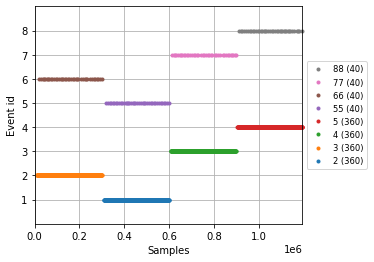

In [6]:
#raw = ddp.read_raw(['/volume-ceph/DDP_projectfolder/dataset/11mnd mmn/010_11_jc_mmn36_wk_mmn25_wk.cnt'])

events, event_dict = mne.events_from_annotations(raw)
fig = mne.viz.plot_events(events, event_id = event_dict)

#### Sort events into standards, deviants, and first-standards.

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']


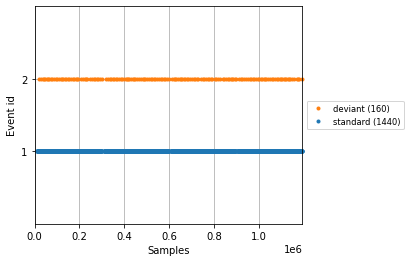

In [7]:
events_3, event_dict_3 = ddp.events_from_raw(raw)
fig = mne.viz.plot_events(events_3, event_id = event_dict_3)

#### Show part of the EEG signal
When a new experiment is chosen, this cell needs to be run again to visualise its EEG data.

Using matplotlib as 2D backend.
Opening raw-browser...


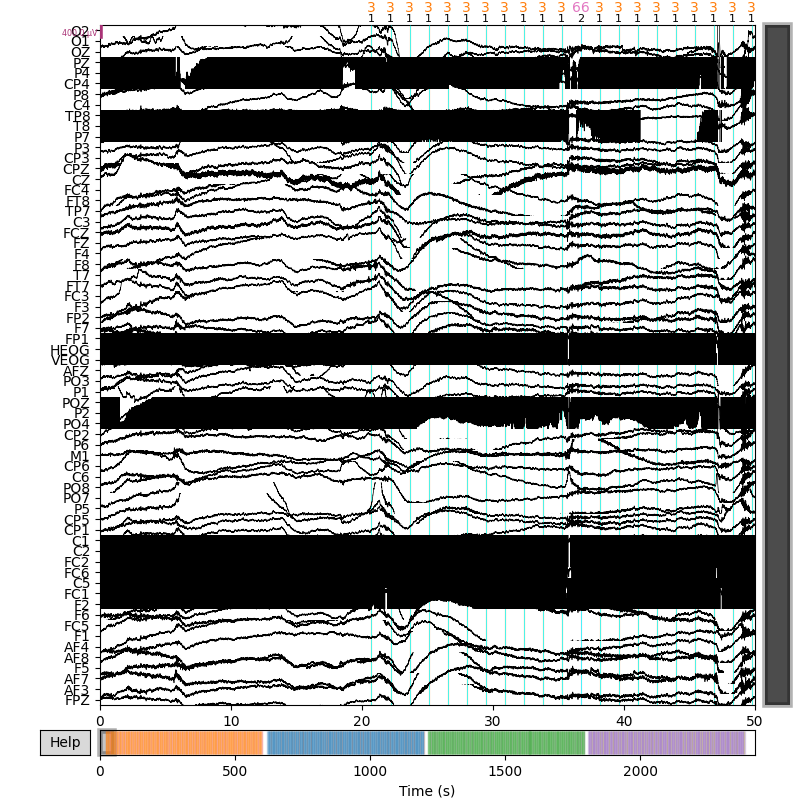

In [8]:
# Makes the plot interactive, comment out if not working:
%matplotlib widget 
fig = mne.viz.plot_raw(raw, events_3, n_channels=100, scalings=200e-6, duration=50, start=0)

<br>
<br>

<a id='3'></a>
## 3. Processing
#### Filtering DDP dataset and rejecting bad trials

The EEG data located in _local_paths.DDP_dataset_ is cleaned with the following techniques:
+ A high-pass filter on the raw EEG sequence with cutoff frequency 0.1 Hz to remove slow trends
+ Splitting the raw data into 1 second epochs in which the event occurs at 0.2s.
+ The epochs are cleaned with the autoreject library. This library contains classes that automatically reject bad trials and repair bad sensors in EEG data. The AutoReject and Ransac classes are used. https://autoreject.github.io/stable/index.html
+ A low-pass filter on the epochs 

The function process_raw splits the raw files up into epochs and saves the events externally. It takes a while to process each file, mainly due to the complexity of the autoreject method. To save some time, multiple raw files are processed simultaniously via multiprocessing.

In [9]:
# for i in range(len(experiments_names)):
#     processing.process_raw(i, experiments_names, experiments_paths, ddp, local_paths.DDP_processed)

## Multiprocessing:
#processing.process_raw_multiprocess(experiments_names, experiments_paths, ddp, local_paths.DDP_processed, verbose=False)

#### Extract valid experiments
Processed files with too few standards and deviants are considered invalid.

In [10]:
valid_experiments = processing.valid_experiments(ddp, local_paths.DDP_epochs_events,
                                                 min_standards = 180, 
                                                 min_deviants = 80)

Analyzed: 906, bad: 201
705 experiments have enough epochs for analysis.


<br>

---
<a id='4'></a>
## 4. The Event Related Potential (ERP)

+ The voltage change in the brain as a response to an event is called the *event-related potential* (ERP)
+ The response difference between a standard and deviant ERP is called the *mismatch response* (MMR).
+ The mismatch response can be analysed to predict differences between participants.

#### Choose experiment to analyse

In [11]:
def load_participant_data(experiment):
    global epochs
    epochs = mne.read_epochs(os.path.join(local_paths.DDP_epochs, experiment + "_epo.fif"), verbose = 0)
    print(f"Loaded experiment: {experiment} ")

ipywidgets.interact(load_participant_data, experiment=valid_experiments);

interactive(children=(Dropdown(description='experiment', options=('101_11', '101_17', '101_35', '102_11', '102…

#### Widget for plotting standard, deviant, and mismatch ERPs

In [20]:
event_type = ipywidgets.RadioButtons(options=["standard", "deviant", "MMN"], 
                                     description='Event type:', 
                                     value="standard")

def plot_ERP_widget(ev):
    evoked = epochs[ev].average()
    fig = evoked.plot(spatial_colors = True)

ui = ipywidgets.HBox([event_type])
out = ipywidgets.interactive_output(plot_ERP_widget, {'ev': event_type})
display(ui, out)

Output()